In [427]:
import io
import networkx as nx
from collections import defaultdict
from collections import Counter
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import sys
import operator
from math import log10, floor
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import timeit

# Function used to round numbers to n significant numbers
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

# Path lengths

The first thing we want to take a look at is path lengths. NetworkX allows us to calculate the shortest path between any pair of articles. We begin by comparing the length of human and shortests paths.

### Exercise

** For each source/target pair in the list of human navigation paths, calculate the shortest path using NetworkX. Plot the distribution of path lengths**


We decided to use undirected graph. We start of by creating a undirected graph from the links.tsv file. We simply run through the file line by line. For each line (except the first 12 lines which only contain information about the dataset) we add an edge to the graph.

In [130]:
# Read in the links.tsv file
file_path = '/Users/GretarAtli/Dropbox/Dtu/Social_graphs_and_interactions/wikispeedia_paths-and-graph/links.tsv'

G = nx.Graph()

with open(file_path, encoding="utf-8") as f:
    lines = f.readlines()
    lines = lines[12:]
    for line in lines:
            line = line.split()
            G.add_edge(line[0],line[1])            
print("number of nodes: {}".format(len(G.nodes())))
print("number of edges: {}".format(len(G.edges())))

number of nodes: 4592
number of edges: 106647


The next step is to go through the finished paths and get the each source target pair

In [141]:
# container that contain the tuple pairs (source, target, length of path)
human_navigation_paths = []

# Read in the links.tsv file
file_path = '/Users/GretarAtli/Dropbox/Dtu/Social_graphs_and_interactions/wikispeedia_paths-and-graph/paths_finished.tsv'

G_humanpaths = nx.Graph()
paths = [] # container for all the completed human paths

with open(file_path, encoding="utf-8") as f:
    lines = f.readlines()
    lines = lines[16:] # Take out the lines that are not links
    for line in lines:
        line = line.split()[3] # Get the path from the line
        line = line.replace(";<","") # Back clicks are represented as "<", here we delete them from the path
        line = line.split(";") # split the path on ; to get an array of websites
        G_humanpaths.add_path(line) # add the path to the human path graph
        paths.append(line)
        source = line[0] # find the source website
        target = line[-1] # find the target website
        
        human_navigation_paths.append((source,target,len(line))) # add the tuple (source, target, length of path)          

Now everything is ready to calculate the shortest path between each source target pair. The reason for the try and catch block is that the node "Wikipedia_Text_of_the_GNU_Free_Documentation_License" is not part of the links list and therefore it is not in our graph. This is most likely just a minor error in the dataset

In [132]:
# Container for the shortest path for each source/target pair. Contains the tuple (source, target, shortest path length)
shortest_paths = []    

for source,target,_ in human_navigation_paths:
    try:
        shortest_paths.append( 
            (
                source,
                target,
                nx.shortest_path_length(G,source=source,target=target)
            )
        )
    except:
        print ("Unexpected error:", sys.exc_info()[0])
        print("target : {}".format(target))
        print("source : {}".format(source))
            

Unexpected error: <class 'networkx.exception.NetworkXError'>
target : Wikipedia_Text_of_the_GNU_Free_Documentation_License
source : Bird


Finally everything is ready to plot up the distribution of path lengths.

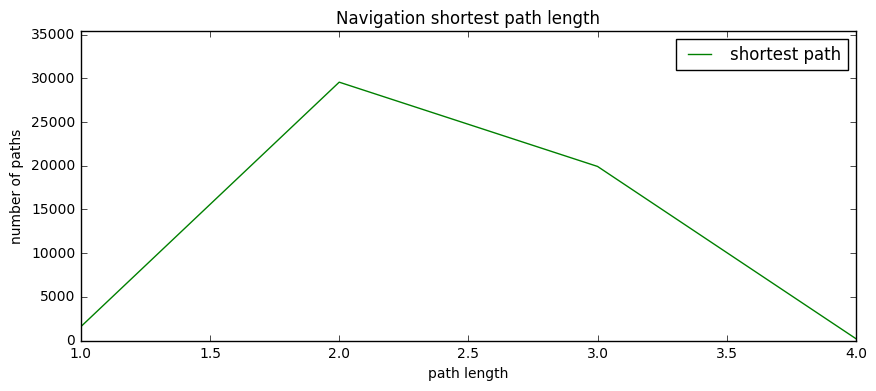

In [133]:
# Get the length of the shortest paths
shortest_path_lengths = [length for source, target, length in shortest_paths]

# plot the distribution
plt.figure(figsize=(10,4))
plt.plot(list(Counter(shortest_path_lengths).keys()), list(Counter(shortest_path_lengths).values()), color="green")
plt.xlim((1, 4))
plt.ylim(0,max(list(Counter(shortest_path_lengths).values()))*1.2)
plt.title("Navigation shortest path length")
plt.xlabel("path length")
plt.ylabel("number of paths")
plt.legend(["shortest path"])
plt.show()

** For each source/target pair, calculate the length of the human path. The dataset contains information on people who regret a navigation step and hit the "back" button in their web-browser. It's up to you how to incorporate that information in the path. Justify your choice. Plot the distribution of human path lengths**

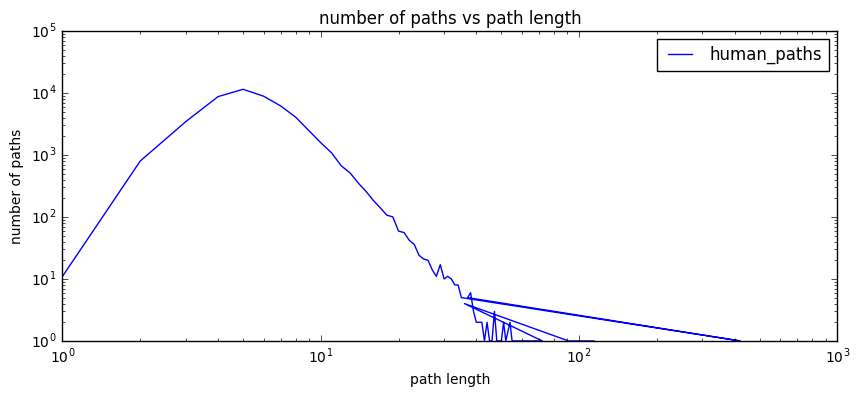

In [134]:
paths_length_counted = Counter([length for target,source,length in human_navigation_paths])

plt.figure(figsize=(10,4))
plt.plot(list(paths_length_counted.keys()), list(paths_length_counted.values()))
plt.xscale("log")
plt.yscale("log")
plt.title("number of paths vs path length")
plt.xlabel("path length")
plt.ylabel("number of paths")
plt.legend(["human_paths"])
plt.show()

** How much longer are the human paths on average? **

In [447]:
human_path_avg = np.mean([length for target,source,length in human_navigation_paths])
shortest_path_avg = np.mean([length for source, target, length in shortest_paths])

print("The human paths average is           {}".format(round_sig(human_path_avg,4) ))
print("The shorest paths average is         {}".format(round_sig(shortest_path_avg,4) ))
print("-------------------------------------------")
print("The difference is                    {}".format(round_sig(human_path_avg - shortest_path_avg,4)))



The human paths average is           6.357
The shorest paths average is         2.365
-------------------------------------------
The difference is                    3.992


** Create scatter plot where each point is a source/target pair, and you have human path lengths on the x-axis and shortests paths on the y-axis. **

We start of by creating two dictionaries. One that contains the shortest path length of every source/target pair. And another that contains every human path length for each source/target pair

In [136]:
shortest_path_dict = defaultdict(set)
human_navigation_path_dict = defaultdict(list)

# get values into the shortest path dictionary
for source, target, length in shortest_paths:
    shortest_path_dict[(source, target)].add(length)

# get values into the human path dictionary
for source, target, length in human_navigation_paths:
    human_navigation_path_dict[(source, target)].append(length)
    
# create a list of tuples of the form (shortest path, human path)
shortest_vs_human = []
for source, target in shortest_path_dict.keys():
    for human_length in human_navigation_path_dict[(source, target)]:
        shortest_vs_human.append(( list(shortest_path_dict[(source,target)])[0], human_length))

Know we have all of the information we need to plot each human path lenght source/target pair point against the shortest path value for that specific source/target pair

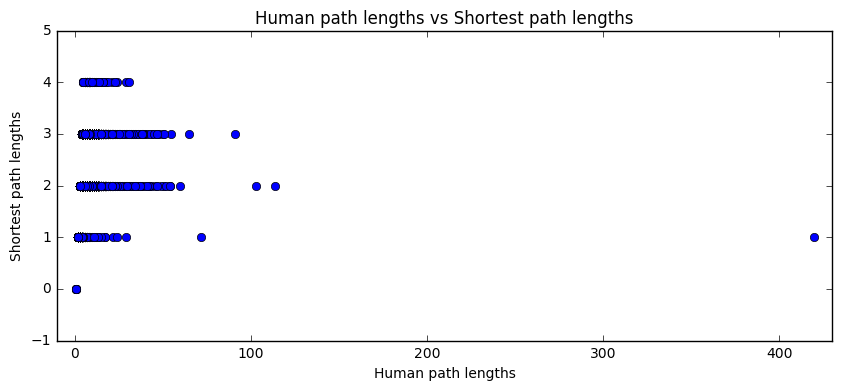

In [379]:
# Create the plot

# We start by reverse ziping the shortest_vs_human tuples array
y,x = zip(*shortest_vs_human)

# The we plot the result
plt.figure(figsize=(10,4))
plt.plot(x, y, "o")
plt.xlim(-10, max(x)+10)
plt.ylim(-1, max(y)+1)
plt.title("Human path lengths vs Shortest path lengths")
plt.xlabel("Human path lengths")
plt.ylabel("Shortest path lengths")
plt.show()

** Is there a correlation between human/shortest path-lengths? What is the correlation. **

You can clearly see on the figure here above that there is no correlation between human/shortest path-lengths. This can investigated further by using the numpy module to calculate the correlation between x and y. The code to accomplish this can be seen here below. The result was that the correlation between x and y is 0.20678837 which supporst the hypothesis that the human/shortest path-lengths are not correlated.

In [380]:
np.corrcoef(x,y)

array([[ 1.        ,  0.20678837],
       [ 0.20678837,  1.        ]])

# Betweenness

** Navigation centrality :** Navigation centrality of node i is the fraction of all naviagtion paths that pass through i. We exclude the source and target from the count. If a node has not been visited by a search, the navigation centrality of that node is defined to be zero.

## Exercise

** Begin by calculating the betweenness centrality and navigation centrality of all nodes in the wikispedia dataset. Note that calculating the betweenness centrality can take quite a long time, so you might start it running in a separate notebook while first estimating it based on the existing human path.**

** First, list the 5 pages with highest navigation centrality.**

In [154]:
navigation = defaultdict(float) # contains the navigation score for each website
nr_of_paths = len(paths) 

# For each website we go through every path in the paths_finished file
# and we count how many times the website is in a path (not source nor target)
for website in G.nodes():
    freq = 0
    for path in paths:
        path = path[1:-1] # Deleting the source and the target from the path 
        if website in path:
            freq += 1
    navigation[website] = freq/nr_of_paths

In [449]:
navigation_sorted = sorted(navigation.items(), key=operator.itemgetter(1), reverse=True)

# print out the list of the 5 pages that have the highest centrality :)
for page, centrality in navigation_sorted[:10]:
    print ("{webpage_s: <26} {centrality_d: <14}".format(
            webpage_s = page, centrality_d = round_sig(centrality,5)
        ))

United_States              0.16766       
Europe                     0.083012      
United_Kingdom             0.073327      
Earth                      0.060525      
England                    0.059472      
Africa                     0.051347      
World_War_II               0.042695      
North_America              0.034705      
Germany                    0.032055      
Animal                     0.031412      


** Second, list the 5 pages with highest betweenness centrality. **

In [139]:
betweenness = nx.betweenness_centrality(G)

In [448]:
betweenness_sorted = sorted(betweenness.items(), key=operator.itemgetter(1), reverse=True)

# print out the list of the 5 pages that have the highest centrality :)
for page, centrality in betweenness_sorted[:10]:
    print ("{webpage_s: <26} {centrality_d: <14}".format(
            webpage_s = page, centrality_d = round_sig(centrality,5)
        ))

United_States              0.12522       
United_Kingdom             0.047387      
Europe                     0.044658      
France                     0.036809      
England                    0.033597      
World_War_II               0.025565      
Germany                    0.023128      
English_language           0.020216      
Africa                     0.019848      
London                     0.019006      


** Compare the two lists. Explain the differences between the two lists in your own words. **

**TODO Tala um the differences herna**

The intersection between the two centralities for the top 10 items are:
---------------------------------------------------------------------
United_States
Europe
United_Kingdom
England
Africa
World_War_II
Germany

The distinctive items in the navigation centrality for the top 10 items are
----------------------------------------------------------------------
Earth
North_America
Animal

The distinctive items in the betweenness centrality for the top 10 items are
----------------------------------------------------------------------
France
English_language
London


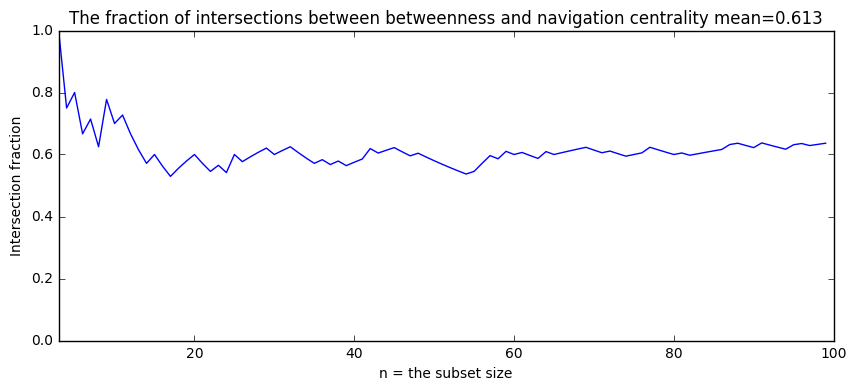

In [220]:
# We will compare the two lists by finding how many item are the same in both lists
# the function prints out how many items are common in each list,
# it also prints out the common websites and the websites that are different in for each centrality

def compareCentralities(navigation_C, betweenness_C, n, p):
    navigation_subset = [website for website,_ in navigation_C[:n]]
    betweenness_subset = [website for website,_ in betweenness_C[:n]]
    
    intersection = [website for website in navigation_subset if website in betweenness_subset]
    
    if p == True:
        print ("The intersection between the two centralities for the top {} items are:".format(n))
        print ("---------------------------------------------------------------------")
        for i in intersection:
            print(i)
        
        print ("\nThe distinctive items in the navigation centrality for the top {} items are".format(n))
        print ("----------------------------------------------------------------------")
        for i in [website for website in navigation_subset if website not in intersection]:
            print(i)
            
        print ("\nThe distinctive items in the betweenness centrality for the top {} items are".format(n))
        print ("----------------------------------------------------------------------")
        for i in [website for website in betweenness_subset if website not in intersection]:
            print(i)
        
    # returns the fraction of intersection items between the two centralities
    return len(intersection)/n

# let´s visualize the difference between these two centralities
compareCentralities(navigation_sorted, betweenness_sorted, 10, True)

intersection_fraction = [compareCentralities(navigation_sorted, betweenness_sorted, n, False) for n in range(3,100)]

# next we plot up the intersection fraction for running n, in the range n=2 up to n=100

plt.figure(figsize=(10,4))
plt.plot(range(3,100),intersection_fraction)
plt.xlim(3,100)
plt.ylim(0,1)
plt.title("The fraction of intersections between betweenness and navigation centrality mean={}"
          .format(round_sig(np.mean(intersection_fraction),3)))
plt.xlabel("n = the subset size")
plt.ylabel("Intersection fraction")
plt.show()

** Create a scatterplot of betweenness centrality vs. navigation centrality.**

Here remember that A vs. B means that A = y axis, B = x axis

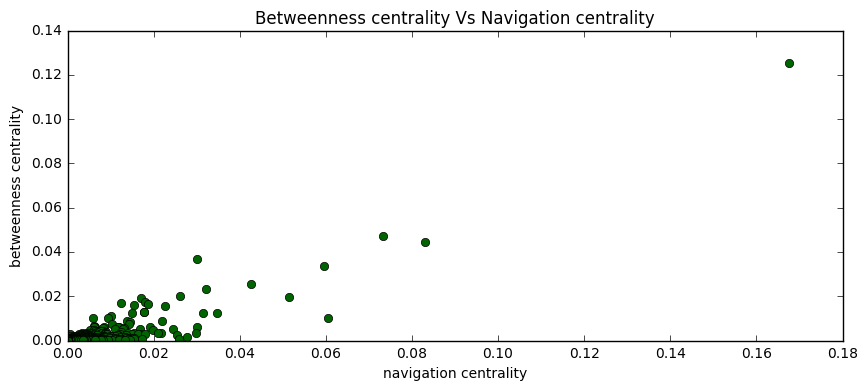

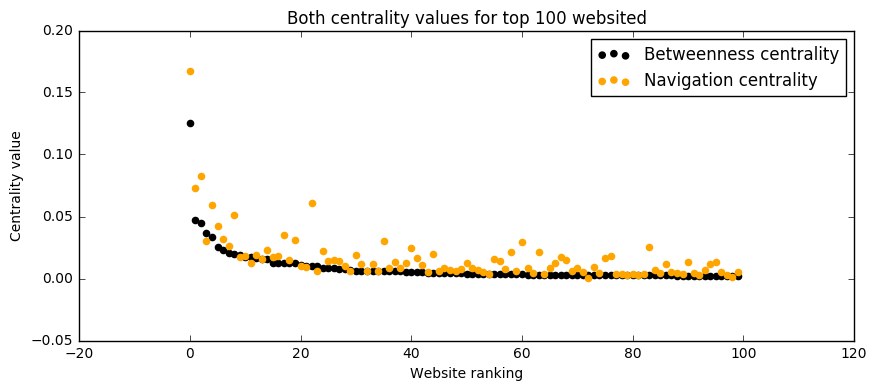

In [259]:
x = range(0,len(betweenness_sorted))
betweenness_values = [value for website,value in betweenness_sorted]
navigation_values = [navigation[website] for website,_ in betweenness_sorted]

plt.figure(figsize=(10,4))
plt.plot(navigation_values, betweenness_values, "o", color="darkgreen")
plt.title("Betweenness centrality Vs Navigation centrality")
plt.xlabel("navigation centrality")
plt.ylabel("betweenness centrality")
plt.show()

# We decided to also plot a scatter plot of the top 100 websited for both centralities 
n= 100
x = range(0,len(betweenness_sorted[0:n]))
betweenness_values = [value for website,value in betweenness_sorted[0:n]]
navigation_values = [navigation[website] for website,_ in betweenness_sorted[0:n]]

plt.figure(figsize=(10,4))
plt.scatter(x, betweenness_values, color="black")
plt.scatter(x, navigation_values, color="orange")
plt.title("Both centrality values for top 100 websited")
plt.xlabel("Website ranking")
plt.ylabel("Centrality value")
plt.legend(["Betweenness centrality", "Navigation centrality"])
plt.show()



**Let's explore the pages that have navigation centrality equal to zero.**

    - How many pages have zero navigation centrality?
    - What is the the page with zero navigation centrality and highest betweenness centrality? Can you explain why no human navigated to this page? Can you explain why the page is central in the actual link network? (For example, you can take a look at the degree of the node).
    - Plot the distribution of betweenness centrality for the pages with zero navigation centrality. My plot on log-log scale:

** How many pages have zero navigation centrality **

In [274]:
# Find all pages with zero navigation centrality
zero_navigation_centrality = [website for website,value in navigation_sorted if value == 0]

print("There are {} pages that have zero navigation centrality".format(len(zero_navigation_centrality)))
print(" -> that is {} percent of all websites ({} in total) in the dataset".format(
        round_sig((len(zero_navigation_centrality)/len(navigation_sorted))*100,3), len(navigation_sorted)
    ))

There are 1187 pages that have zero navigation centrality
 -> that is 25.8 percent of all websites (4592 in total) in the dataset


** What is the page with zero navigation centrality and highest betweenness centrality? Can you explain why no human navigated to this page? Can you explain why the page is central in the actual link network? (For example, you can take a look at the degree of the node). **

The page is *[List of lakes](https://en.wikipedia.org/wiki/List_of_lakes)* which has the betweenness centrality value of 0.0009143. The degree of the page's corresponding link in the graphs is 109, which is interesting when you considere that the average degree in the graphs is 46.449. Initially this came as an surprise but after furter investigation it all started to make sens. The *[List of lakes](https://en.wikipedia.org/wiki/List_of_lakes)* contains a list of lakes by country and therefore can be considered as a some sort of an gateway to wiki pages of the countries. In our earlier work we found out that countries have really high centrality value for both betweenness centrality and navigation centrality. A wikipage of a country is, in most cases, huge page which contain waiste amount of information and links in it. Therefore each country's wikipedia page can be cosidered as a gateway to many different things conserning that country and it is therefore a great decision in the game to click on those pages. A lot of people that finished the game figured this out which can be seen by inspecting the navigation centrality values. However no one figured out that the list of lakes page was a good way to access the countries wikipedia pages which is understandable, at least initially I did not considere it to be a good strategy to click on this page.  

In [318]:
# Find the betweenness centrality value for the pages that have 0 navigation centrality
navigationZero_betweenness = [(website, betweenness[website]) for website in zero_navigation_centrality]

website, betweenness_value = max(navigationZero_betweenness,key=operator.itemgetter(1))

# Find the page with the highest betweenness centrality
print ("The page with zero navigation centrality and highest betweenness centrality is: \n  '{}'".format(
    website
))
print ("  -> with betweenness centrality value of: {}".format(
    round_sig(betweenness_value,4)
))

print ("\nThe degree of the node '{}' in the graph is: {} and the average degree in the graph is {}".format(
        website,
        G.degree(website),
        round_sig(np.mean(list(G.degree().values())),6)
    ))

The page with zero navigation centrality and highest betweenness centrality is: 
  'List_of_lakes'
  -> with betweenness centrality value of: 0.0009143

The degree of the node 'List_of_lakes' in the graph is: 109 and the average degree in the graph is 46.449


** Plot the distribution of betweenness centrality for the pages with zero navigation centrality. My plot on log-log scale ** 

** TODO ath þetta **

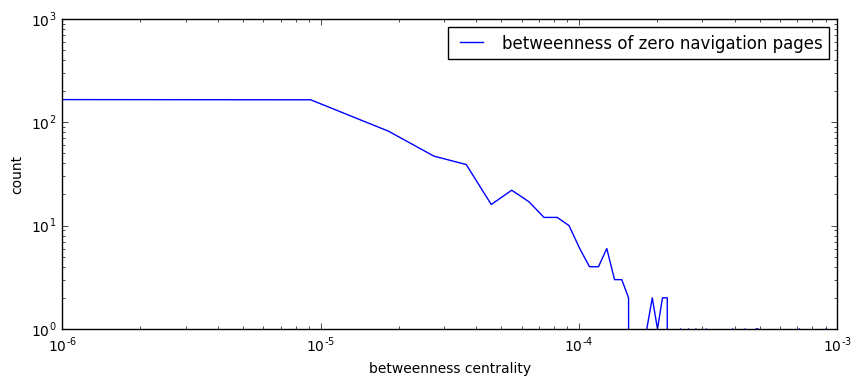

In [451]:
navigationZero_betweenness_values = [value for webpage,value in navigationZero_betweenness]

bins = 100
x,y = np.histogram(navigationZero_betweenness_values, bins)

plt.figure(figsize=(10,4))
plt.plot(y[:-1],x)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("betweenness centrality")
plt.ylabel("count")
plt.legend(["betweenness of zero navigation pages"])
plt.show()



** Now, let's throw out all pages with zero navigation centrality and compare navigation and betweenness centrality for the remaining pages.**

    - What is the correlation between betweenness centrality and navigation centrality?
    - Comment on the top 5 outliers.


In [377]:
# Start by throwing out all pages with zero navigation centrality
navigationZero_betweenness_names = [webpage for webpage,value in navigationZero_betweenness]

# Know we want to get the data on the form (navigation value,betweenness value) for each webpage that is not in 
# navigationZero_betweenness_names
centrality_values = []

# we loop through the keys 
for website,_ in betweenness_sorted:
    if website not in navigationZero_betweenness_names:
        centrality_values.append(
            (
                navigation[website],
                betweenness[website]
            )
        )
        
# Add a small error handling to check if everything is behaving like it should be
for i in navigation_reduced_values:
    if i == 0:
        print("something is wrong")

Now we have the data on a format which allows us to evaluate the correlation quite easily. To evaluate the correlation we will do two things
    - plot up navigation centrality value vs betweenness centrality value for each webpage
    - calculate the correlation between the two centrality methods using the np module

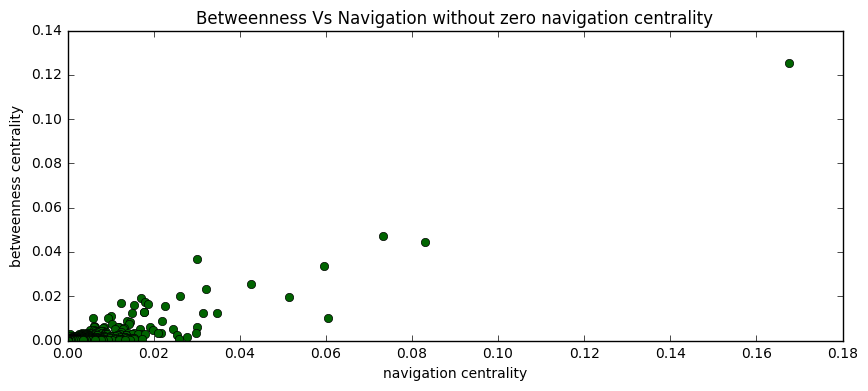

In [371]:
# We start by creating the navigation centrality value vs betweenness centrality value plot

x = range(0,len(betweenness_sorted))
navigation_reduced_values, betweenness_reduced_values = zip(*centrality_values)

plt.figure(figsize=(10,4))
plt.plot(navigation_reduced_values, betweenness_reduced_values, "o", color="darkgreen")
plt.title("Betweenness Vs Navigation without zero navigation centrality")
plt.xlabel("navigation centrality")
plt.ylabel("betweenness centrality")
plt.show()

know we calculate the correlation between the two two centrality methods without zero navigation centrality

In [381]:
np.corrcoef(navigation_reduced_values, betweenness_reduced_values)

array([[ 1.        ,  0.88920305],
       [ 0.88920305,  1.        ]])

** Correlation conclusion**

The correlation between betweenness centrality and navigation centrality is 0.88920302 and therefore we can concluded that the two centrality methods are highly correlated. This is also trivial to see in the Betweenness Vs Navigation plot. 

** Comment on the top 5 outliers. **


** TODO comment on them **

In [411]:
# First we need to find the top 5 outliers. We do that by going through all webpages in the dataset
# For each webpage we add together the betweenness value and the navigation value. 
# We then simply sort the result and find the 5 highest websites

centrality_added = defaultdict(float)
for webpage in betweenness:
    centrality_added[webpage] = navigation[webpage] + navigation[webpage] 
    
centrality_added_sorted = sorted(centrality_added.items(), key = operator.itemgetter(1), reverse=True)

print ("The top 5 outliers are: \n ")


print ("{webpage_s: <26} {navigation_s: <14} {betweenness_s: <14}".format(
    webpage_s = "Webpage",navigation_s = "Navigation", betweenness_s = "Betweenness"))

print ("-----------------------------------------------------")


for website,_ in centrality_added_sorted[:5]:
    print ("{webpage_s: <26} {navigation_s: <14} {betweenness_s: <14}".format(
            webpage_s =  website,
            navigation_s = round_sig(navigation[website],5), 
            betweenness_s = round_sig(betweenness[website],5)
        ))

The top 5 outliers are: 
 
Webpage                    Navigation     Betweenness   
-----------------------------------------------------
United_States              0.16766        0.12522       
Europe                     0.083012       0.044658      
United_Kingdom             0.073327       0.047387      
Earth                      0.060525       0.010079      
England                    0.059472       0.033597      


# Bringing the text into the picture

### Exercises

In [ ]:
folder_uri = "/Users/GretarAtli/Dropbox/Dtu/Social_graphs_and_interactions/plaintext_articles/"

TF_IDF = defaultdict(dict)

# Go through each website and create a 
for website in G.nodes():
    
    file_path = folder_uri + website + ".txt"
    print(file_path)
    counter = 0
    
    with open(file_path, encoding="utf-8") as f:
        lines = f.readlines()
        lines = lines[4:] # Exclude the first four lines of the txt (the article name and copyright)
        
        # Add the article/website to the dictionary TF_IDF
        TF_IDF[website] = {
            "TF" : defaultdict(int),
            "IDF" : defaultdict(float),
            "TF-IDF": defaultdict(float)
        }  
        
        for line in lines:
            
            # S
            line = line.lower()
            
            # Tokenize the line
            tokenizer = RegexpTokenizer(r'\w+')  # We choose to use regularexpression tokenizer
            tokens = tokenizer.tokenize(line) # Get all tokens with the tokenizer
            
            # filter out the stop words and digits
            filtered_words = [w for w in tokens if not w in stopwords.words('english') if not w.isdigit()]
            
            if filtered_words:
                for word in filtered_words:
                    TF_IDF[website]["TF"][word] += 1
            
        

/Users/GretarAtli/Dropbox/Dtu/Social_graphs_and_interactions/plaintext_articles/Great_Lakes_Storm_of_1913.txt
/Users/GretarAtli/Dropbox/Dtu/Social_graphs_and_interactions/plaintext_articles/Belton_House.txt
/Users/GretarAtli/Dropbox/Dtu/Social_graphs_and_interactions/plaintext_articles/Weapon.txt
/Users/GretarAtli/Dropbox/Dtu/Social_graphs_and_interactions/plaintext_articles/Quantum_computer.txt
/Users/GretarAtli/Dropbox/Dtu/Social_graphs_and_interactions/plaintext_articles/Indium.txt
/Users/GretarAtli/Dropbox/Dtu/Social_graphs_and_interactions/plaintext_articles/Bolivia.txt
/Users/GretarAtli/Dropbox/Dtu/Social_graphs_and_interactions/plaintext_articles/Oil_refinery.txt
/Users/GretarAtli/Dropbox/Dtu/Social_graphs_and_interactions/plaintext_articles/Triathlon.txt
/Users/GretarAtli/Dropbox/Dtu/Social_graphs_and_interactions/plaintext_articles/Mixtape.txt
/Users/GretarAtli/Dropbox/Dtu/Social_graphs_and_interactions/plaintext_articles/Extinction.txt
/Users/GretarAtli/Dropbox/Dtu/Social_gra

In [468]:
TF_IDF

defaultdict(dict,
            {'Great_Lakes_Storm_of_1913': {'IDF': defaultdict(float, {}),
              'TF': defaultdict(int,
                          {'105th': 2,
                           'A': 5,
                           'AM': 3,
                           'After': 1,
                           'Aftermath': 1,
                           'Agriculture': 1,
                           'Alberta': 1,
                           'Alexander': 1,
                           'All': 1,
                           'Along': 2,
                           'Alpena': 1,
                           'Also': 1,
                           'America': 1,
                           'An': 1,
                           'Argus': 1,
                           'Around': 1,
                           'Artist': 2,
                           'Arz': 1,
                           'Ashtabula': 1,
                           'Association': 1,
                           'At': 1,
                           'B': 2,
    